In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
from sklearn.metrics import pairwise_distances

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
ep=311
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    




In [3]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
scanpy.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clusterplotdir=os.path.join(clustersavedir_alltrain,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenameAdd='_plottingIdx_progBalanced_'+str(0)
subclusternumbers=[4,6,8,6,6,6,6,4]
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
   

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [5]:
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList[progList==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList[progList==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList[progList==p]='Hyperplasia'

In [6]:
progInclude=np.array(['DCIS and breast tissue','DCIS with early infiltration', 'Hyperplasia','Atypical hyperplasia'])

In [7]:
progIncludeIdx=np.repeat(False,progList.size)
for p in progInclude:
    progIncludeIdx[progList==p]=True
    
coordlist=coordlist[progIncludeIdx]
allImgNames=allImgNames[progIncludeIdx]
clusterRes=clusterRes[progIncludeIdx]
kmeans_sub=kmeans_sub[progIncludeIdx]
progList=progList[progIncludeIdx]

In [8]:
sUnique,sidx_start=np.unique(allImgNames,return_index=True)
progUnique,labels_train,progCounts=np.unique(progList[sidx_start],return_counts=True,return_inverse=True)
for p in range(progUnique.size):
    print(progUnique[p])
    print(progCounts[p])

Atypical hyperplasia
14
DCIS and breast tissue
16
DCIS with early infiltration
30
Hyperplasia
41


In [9]:
def getHistMatrix_clusters(labels,ctlist,nrow=ncluster,ncol=ncluster):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

neighborhoodSize=16*9

In [10]:
#get neighborhood composition

inputNeighborhood=np.zeros((sUnique.size,ncluster*ncluster))
for i in range(sUnique.size):
    imgN=sUnique[i]
    nsamples=np.sum(allImgNames==imgN)
    cluster_i=clusterRes[allImgNames==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist[allImgNames==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood[i]=res.flatten()

In [11]:
_,inputCounts=np.unique(allImgNames,return_counts=True)
inputAll_train=np.concatenate((inputNeighborhood,inputCounts.reshape(-1,1)),axis=1)

In [12]:
#val cores (as validation cores) and val samples (as test cores)
clustersavedir_valcores=os.path.join(sampledir,'cluster_valcores_reordered')
clustersavedir_valsamples=os.path.join(sampledir,'cluster_valsamples_reordered')

with open(os.path.join(datadir,'processed','train_cnnvae_coord_valcores'), 'rb') as output:
    coordlist_valcores=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_coord_valsamples'), 'rb') as output:
    coordlist_valsamples=pickle.load(output)

savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_valcores,savenamecluster+'_all'), 'rb') as output:
    clusterRes_valcores=pickle.load(output)
with open(os.path.join(clustersavedir_valsamples,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes_valsamples=pickle.load(output)
    
kmeans_sub_valcores=(np.zeros(clusterRes_valcores.size)-1).astype(str)
for c in np.unique(clusterRes_valcores):
    subclustersavedir=os.path.join(clustersavedir_valcores,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valcores[clusterRes_valcores==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
    
kmeans_sub_valsamples=(np.zeros(clusterRes_valsamples.size)-1).astype(str)
for c in np.unique(clusterRes_valsamples):
    subclustersavedir=os.path.join(clustersavedir_valsamples,savenamecluster+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
    with open(os.path.join(subclustersavedir,'minibatchkmean_ncluster'+str(subclusterDict[neworder[c]][0])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    kmeans_sub_valsamples[clusterRes_valsamples==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
                

In [13]:
with open(os.path.join(datadir,'processed','train_cnnvae_names_valcores'), 'rb') as input:
    allImgNames_valcores=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_names_valsamples'), 'rb') as input:
    allImgNames_valsamples=pickle.load(input)

In [14]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList_valcores=np.copy(allImgNames_valcores)
for s in np.unique(allImgNames_valcores):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valcores[allImgNames_valcores==s]=prog_s
    
progList_valsamples=np.copy(allImgNames_valsamples)
for s in np.unique(allImgNames_valsamples):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList_valsamples[allImgNames_valsamples==s]=prog_s
    



In [15]:
for p in np.unique(progList_valcores):
    if p=='Ductal carcinoma in situ':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valcores[progList_valcores==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_valcores[progList_valcores==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valcores[progList_valcores==p]='Hyperplasia'

In [16]:
for p in np.unique(progList_valsamples):
    if p=='Ductal carcinoma in situ':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_valsamples[progList_valsamples==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltrati':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'
    
    elif p=='Micropapillary type ductal carcinoma in situ w':
        progList_valsamples[progList_valsamples==p]='DCIS with early infiltration'    
#     elif p=='Atypical hyperlasia':
#         progList_valsamples[progList_valsamples==p]='Hyperplasia'

In [17]:
progIncludeIdx_valcores=np.repeat(False,progList_valcores.size)
for p in progInclude:
    progIncludeIdx_valcores[progList_valcores==p]=True
    
progIncludeIdx_valsamples=np.repeat(False,progList_valsamples.size)
for p in progInclude:
    progIncludeIdx_valsamples[progList_valsamples==p]=True
    
coordlist_valcores=coordlist_valcores[progIncludeIdx_valcores]
allImgNames_valcores=allImgNames_valcores[progIncludeIdx_valcores]
clusterRes_valcores=clusterRes_valcores[progIncludeIdx_valcores]
kmeans_sub_valcores=kmeans_sub_valcores[progIncludeIdx_valcores]
progList_valcores=progList_valcores[progIncludeIdx_valcores]

coordlist_valsamples=coordlist_valsamples[progIncludeIdx_valsamples]
allImgNames_valsamples=allImgNames_valsamples[progIncludeIdx_valsamples]
clusterRes_valsamples=clusterRes_valsamples[progIncludeIdx_valsamples]
kmeans_sub_valsamples=kmeans_sub_valsamples[progIncludeIdx_valsamples]
progList_valsamples=progList_valsamples[progIncludeIdx_valsamples]


In [18]:
sUnique_valcores,sidx_start_valcores=np.unique(allImgNames_valcores,return_index=True)
progUnique_valcores,progCounts_valcores=np.unique(progList_valcores[sidx_start_valcores],return_counts=True)
for p in range(progUnique_valcores.size):
    print(progUnique_valcores[p])
    print(progCounts_valcores[p])

Atypical hyperplasia
15
Hyperplasia
35


In [19]:
sUnique_valsamples,sidx_start_valsamples=np.unique(allImgNames_valsamples,return_index=True)
progUnique_valsamples,progCounts_valsamples=np.unique(progList_valsamples[sidx_start_valsamples],return_counts=True)
for p in range(progUnique_valsamples.size):
    print(progUnique_valsamples[p])
    print(progCounts_valsamples[p])

Atypical hyperplasia
10
DCIS and breast tissue
16
DCIS with early infiltration
29
Hyperplasia
25


In [20]:
#construct labels
labels_valcores=np.zeros(progList_valcores[sidx_start_valcores].size)
for i in range(progUnique.size):
    labels_valcores[progList_valcores[sidx_start_valcores]==progUnique[i]]=i

In [21]:
#construct labels
labels_valsamples=np.zeros(progList_valsamples[sidx_start_valsamples].size)
for i in range(progUnique.size):
    labels_valsamples[progList_valsamples[sidx_start_valsamples]==progUnique[i]]=i

In [22]:
inputNeighborhood_valcores=np.zeros((sUnique_valcores.size,ncluster*ncluster))
for i in range(sUnique_valcores.size):
    imgN=sUnique_valcores[i]
    nsamples=np.sum(allImgNames_valcores==imgN)
    cluster_i=clusterRes_valcores[allImgNames_valcores==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valcores[allImgNames_valcores==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valcores[i]=res.flatten()

In [23]:
inputNeighborhood_valsamples=np.zeros((sUnique_valsamples.size,ncluster*ncluster))
for i in range(sUnique_valsamples.size):
    imgN=sUnique_valsamples[i]
    nsamples=np.sum(allImgNames_valsamples==imgN)
    cluster_i=clusterRes_valsamples[allImgNames_valsamples==imgN]
    neighbor_i=np.tile(cluster_i,(nsamples,1))
    self_i=np.tile(cluster_i.reshape((-1,1)),(1,nsamples))

    dist=pairwise_distances(coordlist_valsamples[allImgNames_valsamples==imgN],n_jobs=-1)
    distIn=np.logical_and(dist<neighborhoodSize,dist>0)
    res=getHistMatrix_clusters(self_i[distIn],neighbor_i[distIn])
    
    inputNeighborhood_valsamples[i]=res.flatten()

In [24]:
_,inputCounts_valcores=np.unique(allImgNames_valcores,return_counts=True)
inputAll_valcores=np.concatenate((inputNeighborhood_valcores,inputCounts_valcores.reshape(-1,1)),axis=1)

In [25]:
_,inputCounts_valsamples=np.unique(allImgNames_valsamples,return_counts=True)
inputAll_valsamples=np.concatenate((inputNeighborhood_valsamples,inputCounts_valsamples.reshape(-1,1)),axis=1)

In [26]:
#concatenate cores
inputAll=np.concatenate((inputAll_train,np.concatenate((inputAll_valcores,inputAll_valsamples),axis=0)),axis=0)
imgNamesAll=np.concatenate((allImgNames[sidx_start],np.concatenate((allImgNames_valcores[sidx_start_valcores],allImgNames_valsamples[sidx_start_valsamples]))))
labelsAll=np.concatenate((labels_train,np.concatenate((labels_valcores,labels_valsamples))))

In [27]:
_,progCountsAll=np.unique(labelsAll,return_counts=True)
weights_train=np.sum(progCountsAll)/progCountsAll

In [29]:
#img sizes
allImgNamesAll=np.concatenate((allImgNames,np.concatenate((allImgNames_valcores,allImgNames_valsamples))))
progListAll=np.concatenate((progList,np.concatenate((progList_valcores,progList_valsamples))))
sidxAll=np.concatenate((sidx_start,np.concatenate((sidx_start_valcores,sidx_start_valsamples))))
coordlistAll=np.concatenate((coordlist,np.concatenate((coordlist_valcores,coordlist_valsamples),axis=0)),axis=0)

imgSizeAll={}
for p in progUnique:
    img_cores=allImgNamesAll[sidxAll[progListAll[sidxAll]==p]]
    pSizes=np.zeros((img_cores.size))
    for si in range(img_cores.size):
        scoord=coordlistAll[allImgNamesAll==img_cores[si]]
        hsize=np.pi*np.square(np.max(scoord[:,0])-np.min(scoord[:,0]))
        vsize=np.pi*np.square(np.max(scoord[:,1])-np.min(scoord[:,1]))
        pSizes[si]=min(hsize,vsize)
    imgSizeAll[p]=pSizes



([<matplotlib.axis.XTick at 0x7f9bc7d76910>,
 [Text(1, 0, 'Atypical hyperplasia'),
  Text(2, 0, 'Breast tissue'),
  Text(3, 0, 'Cancer adjacent normal breast tissue'),
  Text(4, 0, 'DCIS and breast tissue'),
  Text(5, 0, 'DCIS with early infiltration'),
  Text(6, 0, 'Hyperplasia'),
  Text(7, 0, 'Invasive ductal carcinoma'),
  Text(8, 0, 'Invasive ductal carcinoma and breast tissue')])

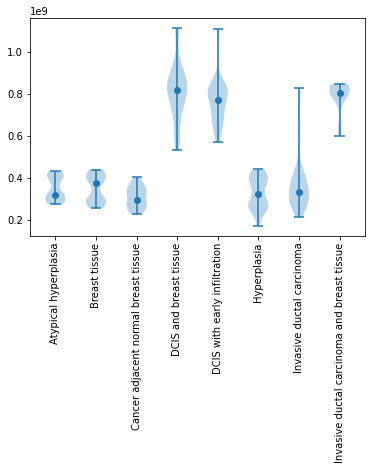

In [30]:
imgSize_median={}
for p in progUnique:
    imgSize_median[p]=np.median(imgSizeAll[p])
plt.violinplot(list(imgSizeAll.values()))
plt.scatter(np.arange(progUnique.size)+1,list(imgSize_median.values()))
plt.xticks(np.arange(progUnique.size)+1,list(imgSizeAll),rotation=90)

In [31]:
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'wb') as output:
    pickle.dump(imgSize_median,output,pickle.HIGHEST_PROTOCOL)

In [28]:
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)

In [29]:
#normalize count
with open(os.path.join(datadir,'processed','imgSizeByPath'), 'rb') as output:
    imgSize_median=pickle.load(output)
areaAll=np.zeros(labelsAll.size)
for s in range(labelsAll.size):
    areaAll[s]=imgSize_median[progUnique[labelsAll.astype(int)][s]]
inputAll[:,-1]=inputAll[:,-1]/areaAll

In [30]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 

# batchsize=4
batchsize=6000
model_str='fc3'

fc_dim1=64
fc_dim2=64
fc_dim3=64


dropout=0.01

name='exp0_pathologyClf_neighbor_clusters_exp0_subset_neighborOnly_crossVal_countAreaNorm_DCIS_AH_H'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)



In [31]:
inputAll=scipy.stats.zscore(inputAll,axis=0)

In [32]:
def train(epoch,trainInput,labels_train):
    t = time.time()
    model.train()
    optimizer.zero_grad()

    pred = model(trainInput)

    loss=lossCE(pred,labels_train)

    loss.backward()
    optimizer.step()

    if epoch%500==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss))
    return loss.item()

In [33]:
inputAll=torch.tensor(inputAll).cuda().float()
labelsAll=torch.tensor(labelsAll).cuda().long()

testepoch=5800
predtest=np.zeros((inputAll.shape[0],np.unique(labels_train).size))
for sampleIdx in range(inputAll.shape[0]):

    trainIdx=np.arange(inputAll.shape[0])!=sampleIdx
    
    seed=3
    torch.manual_seed(seed)
    nclasses=np.unique(labels_train).size
    if use_cuda:
        torch.cuda.manual_seed(seed)

    nfeatures=inputAll.shape[1]
    if model_str=='fc3':
        model = modelsCNN.FC_l3(nfeatures,fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc5':
        model = modelsCNN.FC_l5(nfeatures,fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc1':
        model = modelsCNN.FC_l1(nfeatures,fc_dim1,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())
    if model_str=='fc0':
        model = modelsCNN.FC_l0(nfeatures,nclasses,regrs=False)
        lossCE=torch.nn.CrossEntropyLoss(torch.tensor(weights_train).cuda().float())

    if use_cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loss_ep=[None]*epochs
    val_loss_ep=[None]*epochs
    t_ep=time.time()

    for ep in range(epochs):
        train_loss_ep[ep]=train(ep,inputAll[trainIdx],labelsAll[trainIdx])


        if ep%saveFreq == 0 and ep!=0:
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,imgNamesAll[sampleIdx]+'_'+str(ep)+'.pt'))
        if use_cuda:
            model.cuda()
            torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))

    with open(os.path.join(logsavepath,imgNamesAll[sampleIdx]+'_train_loss'), 'wb') as output:
        pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)

    model.load_state_dict(torch.load(os.path.join(modelsavepath,imgNamesAll[sampleIdx]+'_'+str(testepoch)+'.pt')))
    with torch.no_grad():
        model.cuda()
        model.eval()
        pred = model(inputAll[[sampleIdx]])
        predtest[sampleIdx]=pred.cpu().detach().numpy()

        loss_test=lossCE(pred,labelsAll[[sampleIdx]]).item()

    print(loss_test)

Epoch: 0000 loss_train: 1.3864
Epoch: 0500 loss_train: 0.1225
Epoch: 1000 loss_train: 0.0898
Epoch: 1500 loss_train: 0.0178
Epoch: 2000 loss_train: 0.0043
Epoch: 2500 loss_train: 0.0053
Epoch: 3000 loss_train: 0.0199
Epoch: 3500 loss_train: 0.0044
Epoch: 4000 loss_train: 0.0089
Epoch: 4500 loss_train: 0.0489
Epoch: 5000 loss_train: 0.0034
Epoch: 5500 loss_train: 0.0141
 total time: 7.7013s
0.0
Epoch: 0000 loss_train: 1.3864
Epoch: 0500 loss_train: 0.1258
Epoch: 1000 loss_train: 0.1043
Epoch: 1500 loss_train: 0.0863
Epoch: 2000 loss_train: 0.0070
Epoch: 2500 loss_train: 0.0039
Epoch: 3000 loss_train: 0.0144
Epoch: 3500 loss_train: 0.0032
Epoch: 4000 loss_train: 0.0114
Epoch: 4500 loss_train: 0.0237
Epoch: 5000 loss_train: 0.0035
Epoch: 5500 loss_train: 0.0091
 total time: 7.7724s
0.0
Epoch: 0000 loss_train: 1.3864
Epoch: 0500 loss_train: 0.1165
Epoch: 1000 loss_train: 0.0986
Epoch: 1500 loss_train: 0.0687
Epoch: 2000 loss_train: 0.0067
Epoch: 2500 loss_train: 0.0073
Epoch: 3000 loss_tra

Epoch: 4000 loss_train: 0.0110
Epoch: 4500 loss_train: 0.0081
Epoch: 5000 loss_train: 0.0060
Epoch: 5500 loss_train: 0.0066
 total time: 7.7800s
0.0
Epoch: 0000 loss_train: 1.3875
Epoch: 0500 loss_train: 0.1087
Epoch: 1000 loss_train: 0.1045
Epoch: 1500 loss_train: 0.0350
Epoch: 2000 loss_train: 0.0074
Epoch: 2500 loss_train: 0.0071
Epoch: 3000 loss_train: 0.0208
Epoch: 3500 loss_train: 0.0038
Epoch: 4000 loss_train: 0.0122
Epoch: 4500 loss_train: 0.0022
Epoch: 5000 loss_train: 0.0026
Epoch: 5500 loss_train: 0.0040
 total time: 7.7954s
0.0
Epoch: 0000 loss_train: 1.3874
Epoch: 0500 loss_train: 0.1125
Epoch: 1000 loss_train: 0.1243
Epoch: 1500 loss_train: 0.0364
Epoch: 2000 loss_train: 0.0073
Epoch: 2500 loss_train: 0.0050
Epoch: 3000 loss_train: 0.0134
Epoch: 3500 loss_train: 0.0025
Epoch: 4000 loss_train: 0.0156
Epoch: 4500 loss_train: 0.0069
Epoch: 5000 loss_train: 0.0022
Epoch: 5500 loss_train: 0.0276
 total time: 7.8090s
0.3532223403453827
Epoch: 0000 loss_train: 1.3872
Epoch: 0500

Epoch: 0500 loss_train: 0.1151
Epoch: 1000 loss_train: 0.0703
Epoch: 1500 loss_train: 0.0499
Epoch: 2000 loss_train: 0.0060
Epoch: 2500 loss_train: 0.0065
Epoch: 3000 loss_train: 0.0193
Epoch: 3500 loss_train: 0.0081
Epoch: 4000 loss_train: 0.0101
Epoch: 4500 loss_train: 0.0008
Epoch: 5000 loss_train: 0.0019
Epoch: 5500 loss_train: 0.0156
 total time: 7.4662s
0.0
Epoch: 0000 loss_train: 1.3879
Epoch: 0500 loss_train: 0.0977
Epoch: 1000 loss_train: 0.0850
Epoch: 1500 loss_train: 0.0382
Epoch: 2000 loss_train: 0.0050
Epoch: 2500 loss_train: 0.0148
Epoch: 3000 loss_train: 0.0276
Epoch: 3500 loss_train: 0.0038
Epoch: 4000 loss_train: 0.0150
Epoch: 4500 loss_train: 0.0091
Epoch: 5000 loss_train: 0.0011
Epoch: 5500 loss_train: 0.0168
 total time: 7.4616s
6.661959648132324
Epoch: 0000 loss_train: 1.3879
Epoch: 0500 loss_train: 0.1147
Epoch: 1000 loss_train: 0.0628
Epoch: 1500 loss_train: 0.0454
Epoch: 2000 loss_train: 0.0100
Epoch: 2500 loss_train: 0.0098
Epoch: 3000 loss_train: 0.0118
Epoch:

Epoch: 2000 loss_train: 0.0192
Epoch: 2500 loss_train: 0.0145
Epoch: 3000 loss_train: 0.0160
Epoch: 3500 loss_train: 0.0045
Epoch: 4000 loss_train: 0.0113
Epoch: 4500 loss_train: 0.0057
Epoch: 5000 loss_train: 0.0017
Epoch: 5500 loss_train: 0.0023
 total time: 7.4447s
0.0006560318870469928
Epoch: 0000 loss_train: 1.3889
Epoch: 0500 loss_train: 0.0886
Epoch: 1000 loss_train: 0.0301
Epoch: 1500 loss_train: 0.0748
Epoch: 2000 loss_train: 0.0089
Epoch: 2500 loss_train: 0.0073
Epoch: 3000 loss_train: 0.0207
Epoch: 3500 loss_train: 0.0052
Epoch: 4000 loss_train: 0.0131
Epoch: 4500 loss_train: 0.0614
Epoch: 5000 loss_train: 0.0022
Epoch: 5500 loss_train: 0.0122
 total time: 7.4541s
3.4927710657939315e-05
Epoch: 0000 loss_train: 1.3888
Epoch: 0500 loss_train: 0.1017
Epoch: 1000 loss_train: 0.0525
Epoch: 1500 loss_train: 0.0664
Epoch: 2000 loss_train: 0.0054
Epoch: 2500 loss_train: 0.0082
Epoch: 3000 loss_train: 0.0198
Epoch: 3500 loss_train: 0.0039
Epoch: 4000 loss_train: 0.0051
Epoch: 4500 lo

Epoch: 2000 loss_train: 0.0300
Epoch: 2500 loss_train: 0.0097
Epoch: 3000 loss_train: 0.0166
Epoch: 3500 loss_train: 0.0049
Epoch: 4000 loss_train: 0.0025
Epoch: 4500 loss_train: 0.0109
Epoch: 5000 loss_train: 0.0017
Epoch: 5500 loss_train: 0.0423
 total time: 7.4494s
37.705745697021484
Epoch: 0000 loss_train: 1.3900
Epoch: 0500 loss_train: 0.0806
Epoch: 1000 loss_train: 0.0554
Epoch: 1500 loss_train: 0.0400
Epoch: 2000 loss_train: 0.0114
Epoch: 2500 loss_train: 0.0077
Epoch: 3000 loss_train: 0.0172
Epoch: 3500 loss_train: 0.0187
Epoch: 4000 loss_train: 0.0090
Epoch: 4500 loss_train: 0.0367
Epoch: 5000 loss_train: 0.0029
Epoch: 5500 loss_train: 0.0150
 total time: 7.4599s
0.0005133026279509068
Epoch: 0000 loss_train: 1.3899
Epoch: 0500 loss_train: 0.0968
Epoch: 1000 loss_train: 0.0760
Epoch: 1500 loss_train: 0.0229
Epoch: 2000 loss_train: 0.0065
Epoch: 2500 loss_train: 0.0107
Epoch: 3000 loss_train: 0.0162
Epoch: 3500 loss_train: 0.0056
Epoch: 4000 loss_train: 0.0129
Epoch: 4500 loss_t

Epoch: 1000 loss_train: 0.0512
Epoch: 1500 loss_train: 0.0294
Epoch: 2000 loss_train: 0.0096
Epoch: 2500 loss_train: 0.0054
Epoch: 3000 loss_train: 0.0201
Epoch: 3500 loss_train: 0.0167
Epoch: 4000 loss_train: 0.0312
Epoch: 4500 loss_train: 0.0518
Epoch: 5000 loss_train: 0.0015
Epoch: 5500 loss_train: 0.0201
 total time: 7.4652s
0.0
Epoch: 0000 loss_train: 1.3900
Epoch: 0500 loss_train: 0.0871
Epoch: 1000 loss_train: 0.0610
Epoch: 1500 loss_train: 0.0302
Epoch: 2000 loss_train: 0.0240
Epoch: 2500 loss_train: 0.0156
Epoch: 3000 loss_train: 0.0189
Epoch: 3500 loss_train: 0.0139
Epoch: 4000 loss_train: 0.0242
Epoch: 4500 loss_train: 0.0020
Epoch: 5000 loss_train: 0.0017
Epoch: 5500 loss_train: 0.0287
 total time: 7.4525s
3.421248038648628e-05
Epoch: 0000 loss_train: 1.3899
Epoch: 0500 loss_train: 0.0845
Epoch: 1000 loss_train: 0.0673
Epoch: 1500 loss_train: 0.0286
Epoch: 2000 loss_train: 0.0070
Epoch: 2500 loss_train: 0.0068
Epoch: 3000 loss_train: 0.0227
Epoch: 3500 loss_train: 0.0070
Ep

Epoch: 4000 loss_train: 0.0369
Epoch: 4500 loss_train: 0.0009
Epoch: 5000 loss_train: 0.0030
Epoch: 5500 loss_train: 0.0395
 total time: 7.4488s
0.00014232576359063387
Epoch: 0000 loss_train: 1.3889
Epoch: 0500 loss_train: 0.0848
Epoch: 1000 loss_train: 0.0431
Epoch: 1500 loss_train: 0.0403
Epoch: 2000 loss_train: 0.0130
Epoch: 2500 loss_train: 0.0113
Epoch: 3000 loss_train: 0.0128
Epoch: 3500 loss_train: 0.0039
Epoch: 4000 loss_train: 0.0461
Epoch: 4500 loss_train: 0.0050
Epoch: 5000 loss_train: 0.0035
Epoch: 5500 loss_train: 0.0221
 total time: 7.4663s
0.0
Epoch: 0000 loss_train: 1.3886
Epoch: 0500 loss_train: 0.0584
Epoch: 1000 loss_train: 0.0334
Epoch: 1500 loss_train: 0.0302
Epoch: 2000 loss_train: 0.0184
Epoch: 2500 loss_train: 0.0118
Epoch: 3000 loss_train: 0.0166
Epoch: 3500 loss_train: 0.0042
Epoch: 4000 loss_train: 0.0582
Epoch: 4500 loss_train: 0.0038
Epoch: 5000 loss_train: 0.0111
Epoch: 5500 loss_train: 0.0472
 total time: 7.4661s
3.325251340866089
Epoch: 0000 loss_train: 

Epoch: 1000 loss_train: 0.0998
Epoch: 1500 loss_train: 0.0213
Epoch: 2000 loss_train: 0.0174
Epoch: 2500 loss_train: 0.0279
Epoch: 3000 loss_train: 0.0053
Epoch: 3500 loss_train: 0.0093
Epoch: 4000 loss_train: 0.0176
Epoch: 4500 loss_train: 0.0021
Epoch: 5000 loss_train: 0.0047
Epoch: 5500 loss_train: 0.0357
 total time: 7.4557s
0.0
Epoch: 0000 loss_train: 1.3896
Epoch: 0500 loss_train: 0.1117
Epoch: 1000 loss_train: 0.0692
Epoch: 1500 loss_train: 0.0243
Epoch: 2000 loss_train: 0.0127
Epoch: 2500 loss_train: 0.0223
Epoch: 3000 loss_train: 0.0086
Epoch: 3500 loss_train: 0.0021
Epoch: 4000 loss_train: 0.1252
Epoch: 4500 loss_train: 0.0057
Epoch: 5000 loss_train: 0.0074
Epoch: 5500 loss_train: 0.0435
 total time: 7.4534s
0.0008045773720368743
Epoch: 0000 loss_train: 1.3894
Epoch: 0500 loss_train: 0.0891
Epoch: 1000 loss_train: 0.0698
Epoch: 1500 loss_train: 0.0343
Epoch: 2000 loss_train: 0.0201
Epoch: 2500 loss_train: 0.0408
Epoch: 3000 loss_train: 0.0194
Epoch: 3500 loss_train: 0.0053
Ep

Epoch: 3500 loss_train: 0.0115
Epoch: 4000 loss_train: 0.0375
Epoch: 4500 loss_train: 0.0064
Epoch: 5000 loss_train: 0.0141
Epoch: 5500 loss_train: 0.0226
 total time: 7.4670s
2.3841855067985307e-07
Epoch: 0000 loss_train: 1.3908
Epoch: 0500 loss_train: 0.0929
Epoch: 1000 loss_train: 0.0753
Epoch: 1500 loss_train: 0.0460
Epoch: 2000 loss_train: 0.0052
Epoch: 2500 loss_train: 0.0154
Epoch: 3000 loss_train: 0.0037
Epoch: 3500 loss_train: 0.0049
Epoch: 4000 loss_train: 0.0488
Epoch: 4500 loss_train: 0.0025
Epoch: 5000 loss_train: 0.0030
Epoch: 5500 loss_train: 0.0118
 total time: 7.4697s
0.001994883641600609
Epoch: 0000 loss_train: 1.3907
Epoch: 0500 loss_train: 0.0779
Epoch: 1000 loss_train: 0.0891
Epoch: 1500 loss_train: 0.0657
Epoch: 2000 loss_train: 0.0102
Epoch: 2500 loss_train: 0.0124
Epoch: 3000 loss_train: 0.0050
Epoch: 3500 loss_train: 0.0091
Epoch: 4000 loss_train: 0.0240
Epoch: 4500 loss_train: 0.0016
Epoch: 5000 loss_train: 0.0047
Epoch: 5500 loss_train: 0.0406
 total time: 7.

Epoch: 4000 loss_train: 0.0109
Epoch: 4500 loss_train: 0.0047
Epoch: 5000 loss_train: 0.0029
Epoch: 5500 loss_train: 0.0180
 total time: 7.4534s
2.9444261599564925e-05
Epoch: 0000 loss_train: 1.3947
Epoch: 0500 loss_train: 0.0717
Epoch: 1000 loss_train: 0.1103
Epoch: 1500 loss_train: 0.0391
Epoch: 2000 loss_train: 0.0071
Epoch: 2500 loss_train: 0.0341
Epoch: 3000 loss_train: 0.0073
Epoch: 3500 loss_train: 0.0021
Epoch: 4000 loss_train: 0.0174
Epoch: 4500 loss_train: 0.0129
Epoch: 5000 loss_train: 0.0184
Epoch: 5500 loss_train: 0.0258
 total time: 7.4566s
2.3841855067985307e-07
Epoch: 0000 loss_train: 1.3945
Epoch: 0500 loss_train: 0.0653
Epoch: 1000 loss_train: 0.1003
Epoch: 1500 loss_train: 0.0407
Epoch: 2000 loss_train: 0.0092
Epoch: 2500 loss_train: 0.0242
Epoch: 3000 loss_train: 0.0050
Epoch: 3500 loss_train: 0.0017
Epoch: 4000 loss_train: 0.0205
Epoch: 4500 loss_train: 0.0203
Epoch: 5000 loss_train: 0.0181
Epoch: 5500 loss_train: 0.0249
 total time: 7.4733s
1.9073468138230965e-06


Epoch: 4000 loss_train: 0.0289
Epoch: 4500 loss_train: 0.0107
Epoch: 5000 loss_train: 0.0157
Epoch: 5500 loss_train: 0.0041
 total time: 7.4582s
0.009262802079319954
Epoch: 0000 loss_train: 1.3940
Epoch: 0500 loss_train: 0.0759
Epoch: 1000 loss_train: 0.0861
Epoch: 1500 loss_train: 0.0337
Epoch: 2000 loss_train: 0.0062
Epoch: 2500 loss_train: 0.0470
Epoch: 3000 loss_train: 0.0027
Epoch: 3500 loss_train: 0.0017
Epoch: 4000 loss_train: 0.0130
Epoch: 4500 loss_train: 0.0290
Epoch: 5000 loss_train: 0.0048
Epoch: 5500 loss_train: 0.0409
 total time: 7.4082s
0.01718476228415966
Epoch: 0000 loss_train: 1.3944
Epoch: 0500 loss_train: 0.1011
Epoch: 1000 loss_train: 0.0834
Epoch: 1500 loss_train: 0.0197
Epoch: 2000 loss_train: 0.0105
Epoch: 2500 loss_train: 0.0220
Epoch: 3000 loss_train: 0.0173
Epoch: 3500 loss_train: 0.0037
Epoch: 4000 loss_train: 0.0357
Epoch: 4500 loss_train: 0.0223
Epoch: 5000 loss_train: 0.0172
Epoch: 5500 loss_train: 0.0142
 total time: 7.4557s
1.1920928244535389e-07
Epoch

In [34]:
with open(os.path.join(logsavepath,'crossVal_loss'), 'wb') as output:
    pickle.dump(predtest, output, pickle.HIGHEST_PROTOCOL)

In [35]:
predtest_label=np.argmax(predtest,axis=1)

In [36]:
res=pd.DataFrame({'sampleName':imgNamesAll,'true':progUnique[labelsAll.cpu().numpy()],'predicted':progUnique[predtest_label]})
res.to_csv(os.path.join(plotsavepath,'predictions.csv'))

In [43]:
progInclude=np.array(['Hyperplasia','Atypical hyperplasia','DCIS and breast tissue',  'DCIS with early infiltration'])

In [44]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',order=progInclude):
    res=np.zeros((order.size,order.size))
    for li in range(res.shape[0]):
        l=order[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=order[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=order[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=order[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(order.size))
    ax.set_yticklabels(order)
    ax.set_xticks(np.arange(order.size))
    ax.set_xticklabels(order)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    
plotCTcomp(progUnique[labelsAll.cpu().numpy()],progUnique[predtest_label],plotsavepath,'confusion'+str(testepoch),False)

In [46]:
plotCTcomp(progUnique[labelsAll.cpu().numpy()][:sidx_start.size],progUnique[predtest_label][:sidx_start.size],plotsavepath,'confusion_excludeValSamples'+str(testepoch),False)

In [39]:
res

,sampleName,true,predicted
0,br1003a_1_cytokeratin_555_aSMA_647_hoechst_I1,Breast tissue,Breast tissue
1,br1003a_1_cytokeratin_555_aSMA_647_hoechst_I10,Breast tissue,Breast tissue
2,br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2,Breast tissue,DCIS with early infiltration
3,br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3,Breast tissue,Breast tissue
4,br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7,Breast tissue,Breast tissue
...,...,...,...
407,br8018a_2_cytokeratin_555_ki67_647_hoechst_G6,Invasive ductal carcinoma,Invasive ductal carcinoma
408,br8018a_2_cytokeratin_555_ki67_647_hoechst_H2,Cancer adjacent normal breast tissue,Invasive ductal carcinoma
409,br8018a_2_cytokeratin_555_ki67_647_hoechst_H3,Cancer adjacent normal breast tissue,Cancer adjacent normal breast tissue
410,br8018a_2_cytokeratin_555_ki67_647_hoechst_H4,Cancer adjacent normal breast tissue,Cancer adjacent normal breast tissue
